Cet exemple est adapté de https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/ et nécessite PennyLane 0.40.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Le but de cet exercice est d'utiliser un circuit variationnel à un seul qubit pour modéliser une fonction sinusoïdale. Nous allons d'abord créer les données sinusoïdales.

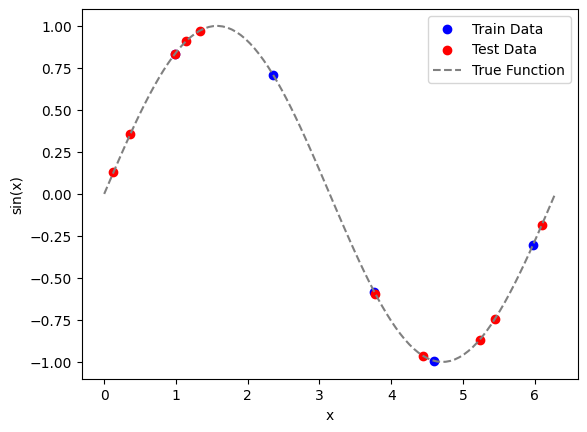

Train Data:
x_train: [0.98029403 2.35330497 3.76148219 4.59925358 5.97351416]
y_train: [ 0.83066112  0.70914702 -0.58094525 -0.99360701 -0.30474544]

Test Data:
x_test: [0.12933619 0.3649501  0.98014248 1.14243996 1.33416598 3.77691701
 4.44895122 5.23039137 5.44234523 6.09412333]
y_test: [ 0.12897591  0.35690268  0.83057673  0.90964971  0.97213343 -0.59343861
 -0.96550049 -0.86881002 -0.74520358 -0.18793767]


In [4]:
# Set random seed for reproducibility
np.random.seed(42)
train_size = 5
test_size = 10

# Generate 5 random x values in the range [0, 2π]
X = np.sort(2 * np.pi * np.random.rand(train_size))
Y = np.sin(X)

# Generate 5 test points in the same range
X_test = np.sort(2 * np.pi * np.random.rand(test_size))
Y_test = np.sin(X_test)

# Plot the training and testing data
plt.scatter(X, Y, color='blue', label='Train Data')
plt.scatter(X_test, Y_test, color='red', label='Test Data')
plt.plot(np.linspace(0, 2*np.pi, 100), np.sin(np.linspace(0, 2*np.pi, 100)), '--', color='gray', label='True Function')
plt.legend()
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.show()

# Print the generated data
print("Train Data:")
print("x_train:", X)
print("y_train:", Y)

print("\nTest Data:")
print("x_test:", X_test)
print("y_test:", Y_test)

Définissons maintenant notre circuit variationnel. Nous allons d'abord exécuter le circuit en simulation.
#Question : there is no entanglement in this circuit? Is it just a bad neural network? probably? Could be interesting to test a simple NN here...Even a simple least squares fit would work great. Maybe the point is "should" I do this? and the answer is No lol

Some blabla here about why we encode the training data point (which is a floating point) into the X rotation 

La porte qml.Rot applique une rotation générale sur un qubit en combinant trois rotations autour des axes $Z$ et $Y$:  

\begin{equation}
R(\phi, \theta, \omega) = R_Z(\omega) R_Y(\theta) R_Z(\phi)
\end{equation}

Les angles $\phi$, $\theta$, et $\omega$ seront les parameteres à optimiser.

In [35]:
#Créer le device
dev = qml.device('default.qubit', wires=1, shots = 1000)

number_of_circuit_executions = 0
#Définir le circuit 
@qml.qnode(dev)
def quantum_circuit(datapoint, params):
    #Util
    global number_of_circuit_executions
    number_of_circuit_executions += 1
    
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)  #THE DATA ENCODING IS HERE ! UNDERSTAND THIS BETTER
    
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)

    return qml.expval(qml.PauliZ(wires=0))

Voici le circuit variationel 

(<Figure size 500x200 with 1 Axes>, <Axes: >)

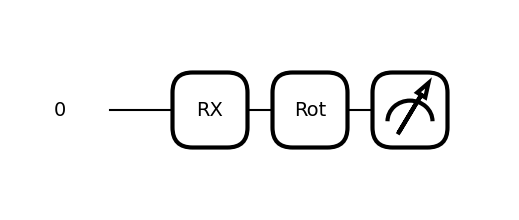

In [28]:
qml.draw_mpl(quantum_circuit)(X[0], [0.1,0.1,0.1] )

La partie "quantique" de l'algorithme est complétée. Il suffit maintenant de définir la partie classique : fonction de perte, fonction de coût et optimisateur

In [6]:
def loss_func(predictions):
    """Least squares loss function."""
    return np.sum((np.array(predictions) - Y) ** 2)
    
def cost_fn(params):
    """Computes the cost based on the predictions outputted by the quantum circuit ."""
    predictions = np.array([quantum_circuit(x, params) for x in X])
    return loss_func(predictions)

PennyLane propose plusieurs optimiseurs, mais leur mise à l’échelle varie. Par exemple, l’algorithme de descente de gradient utilisé pour différencier les circuits quantiques dans PennyLane nécessite deux appels de circuit par paramètre, et ce à chaque itération. En revanche, des méthodes comme l’optimiseur SPSA se contentent d’une approximation du gradient et ne requièrent que deux appels de circuit par étape, quel que soit le nombre de paramètres. Comme en apprentissage machine classique, le choix de l’optimiseur dépend du problème à résoudre.

In [7]:
#opt = qml.AdamOptimizer()
opt = qml.GradientDescentOptimizer(stepsize = 0.3)

Entraînons notre modèle

In [11]:
#Estimation initiale
params = np.array([0.1,0.1,0.1],requires_grad=True)

# Entrainons le mode
steps = 20
cost_arr = []
for i in range(steps):
    # Over each step the parameters change to give a better cost
    params, prev_cost = opt.step_and_cost(cost_fn,params)
    cost_arr.append(prev_cost)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {prev_cost}')

Step = 0 Cost = 4.678143892079112
Step = 10 Cost = 0.01147076887961409


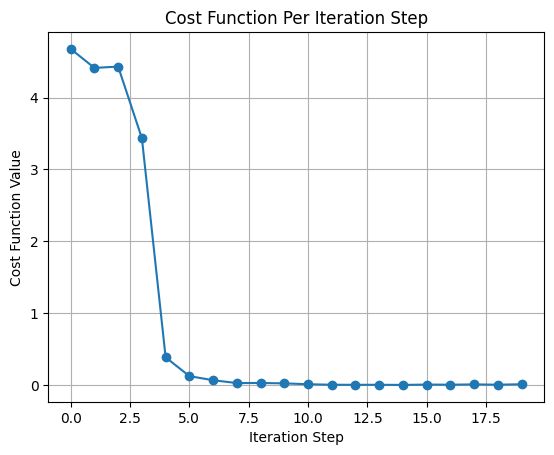

In [12]:
plt.plot(range(len(cost_arr)), cost_arr, marker='o', linestyle='-')
plt.xlabel("Iteration Step")
plt.ylabel("Cost Function Value")
plt.title("Cost Function Per Iteration Step")
plt.grid()
plt.show()

In [13]:
# Step 6 - Test and graph your results!
test_predictions = []
for x_test in X_test:
    prediction = quantum_circuit(x_test,params) #Another call to the quantum circuit 
    test_predictions.append(prediction)

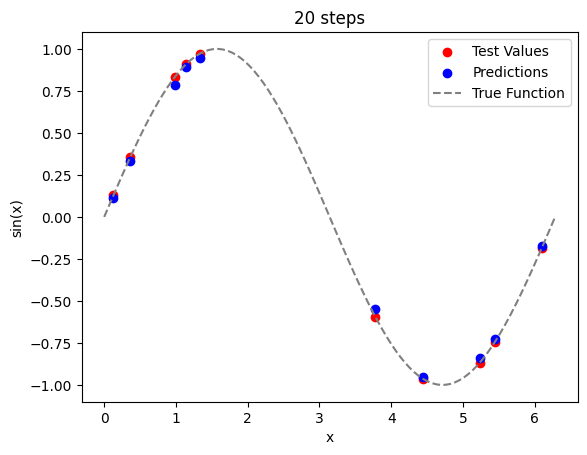

In [14]:
plt.scatter(X_test, Y_test, color='red', label='Test Values')
plt.scatter(X_test, test_predictions, color='blue', label='Predictions')
plt.plot(np.linspace(0, 2*np.pi, 100), np.sin(np.linspace(0, 2*np.pi, 100)), '--', color='gray', label='True Function')

plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title(f'{steps} steps')
plt.legend()
plt.show()

In [19]:
import os
from dotenv import load_dotenv

from pennylane_calculquebec.API.client import MonarqClient
from pennylane_calculquebec.processing.config import MonarqDefaultConfig, PrintDefaultConfig

In [20]:
load_dotenv()
HOST_ENV = os.getenv("HOST")
USER_ENV = os.getenv("CQ_USER")
ACCESS_TOKEN_ENV = os.getenv("ACCESS_TOKEN")
REALM_ENV = os.getenv("REALM")

my_client = MonarqClient(HOST_ENV , USER_ENV, ACCESS_TOKEN_ENV)

In [43]:
my_config = MonarqDefaultConfig("yukon") 

In [44]:
dev_mnq = qml.device("monarq.backup", client=my_client, wires = 1, shots = 1000, processing_config = my_config)

In [45]:
number_of_circuit_executions = 0
#Définir le circuit 
@qml.qnode(dev_mnq)
def quantum_circuit(datapoint, params):
    #Util
    global number_of_circuit_executions
    number_of_circuit_executions += 1
    
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)  
    
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)

    return qml.expval(qml.PauliZ(wires=0))

In [46]:
# Il faut s'assurer de redefinir la fonction de cout afin qu'elle utilise quantum_circuit lié à dev_mnq
def cost_fn(params):
    """Computes the cost based on the predictions outputted by the quantum circuit ."""
    predictions = np.array([quantum_circuit(x, params) for x in X])
    return loss_func(predictions)

In [47]:
#Estimation initiale
params = np.array([0.1,0.1,0.1],requires_grad=True)

# Entrainons le mode
steps = 20
cost_arr = []
for i in range(steps):
    # Over each step the parameters change to give a better cost
    params, prev_cost = opt.step_and_cost(cost_fn,params)
    cost_arr.append(prev_cost)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {prev_cost}')

Step = 0 Cost = 3.585102734994452
Step = 10 Cost = 0.025203292427004358


KeyboardInterrupt: 

In [ ]:
print(number_of_circuit_executions)

In [ ]:
plt.plot(range(len(cost_arr)), cost_arr, marker='o', linestyle='-')
plt.xlabel("Iteration Step")
plt.ylabel("Cost Function Value")
plt.title("Cost Function Per Iteration Step")
plt.grid()
plt.show()

In [ ]:
# Step 6 - Test and graph your results!
test_predictions = []
for x_test in X_test:
    prediction = quantum_circuit(x_test,params) #Another call to the quantum circuit 
    test_predictions.append(prediction)

In [ ]:
plt.scatter(X_test, Y_test, color='red', label='Test Values')
plt.scatter(X_test, test_predictions, color='blue', label='Predictions')
plt.plot(np.linspace(0, 2*np.pi, 100), np.sin(np.linspace(0, 2*np.pi, 100)), '--', color='gray', label='True Function')

plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title(f'{steps} steps')
plt.legend()
plt.show()